In [3]:
# Supervised models: Classification (cluster) + Regression (target_price)
# Paste in a notebook cell and run. Adjust CSV paths if different.

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
!pip install lightgbm
import lightgbm as lgb
import joblib
from sklearn.impute import SimpleImputer
import sklearn
from packaging import version
from lightgbm import early_stopping, log_evaluation

# ------------------ Parameters ------------------
CSV_PATH = "asset_clusters_with_macro.csv"   # file produced by unsupervised step
OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ Load data ------------------
df = pd.read_csv(CSV_PATH, low_memory=False)
print("rows:", len(df))
df.head()

# ------------- Quick cleanup & guard -----------------
for c in ['target_price','price_latest_reg','price_avg_12m','price_avg_6m','price_avg_3m',
          'pct_chg_12m','pct_chg_3m','pct_chg_1m','vol_12m','nearest_dist_km']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# ✅ Fix age calculation if missing
if 'construction date' in df.columns and ('age' not in df.columns or df['age'].isnull().sum()>0):
    CURRENT_YEAR = 2024
    df['construction_year'] = pd.to_numeric(df['construction date'], errors='coerce')
    df['age'] = np.where(df['construction_year'].notnull(), CURRENT_YEAR - df['construction_year'], np.nan)
    df.loc[df['age'] < 0, 'age'] = np.nan
    df.loc[df['age'] > 120, 'age'] = 120

# ------------------ Features ------------------
num_features = [
    'building rentable square feet', 'available square feet',
    'age', 'utilization', 'nearest_dist_km',
    'price_latest_reg', 'price_avg_12m', 'vol_12m', 'pct_chg_12m'
]
num_features = [f for f in num_features if f in df.columns]

cat_features = [c for c in ['asset_type_simple','owned_or_leased','RegionName','State'] if c in df.columns]
geo_features = [f for f in ['latitude','longitude'] if f in df.columns]

FEATURES_BASE = num_features + cat_features + geo_features
print("Using features:", FEATURES_BASE)

# ------------------ Prepare dataset for classification ------------------
y_class = df['macro_cluster'].astype(int)
X = df[FEATURES_BASE].copy()

numeric_cols = [c for c in X.columns if c in num_features + geo_features]
categorical_cols = [c for c in X.columns if c in cat_features]

# ✅ OneHotEncoder version-agnostic fix
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', onehot)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

# ------------------ Classification model ------------------
lgb_clf = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05)

clf_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', lgb_clf)])

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)
print("Train/test sizes:", X_train.shape, X_test.shape)

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("Accuracy (test):", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

clf_path = os.path.join(OUT_DIR, "cluster_classifier_lgb.joblib")
joblib.dump(clf_pipeline, clf_path)

# ------------------ Regression model ------------------
reg_df = df.copy()
reg_df = reg_df[FEATURES_BASE + ['macro_cluster','target_price']].dropna(subset=['target_price'])
reg_df['log_target'] = np.log1p(reg_df['target_price'])

X_reg = reg_df[FEATURES_BASE + ['macro_cluster']].copy()
y_reg = reg_df['log_target']

numeric_cols_reg = [c for c in X_reg.columns if c in num_features + geo_features]
categorical_cols_reg = [c for c in cat_features if c in X_reg.columns] + ['macro_cluster']

# Preprocessor
preprocessor_reg = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols_reg),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), ('onehot', onehot)]), categorical_cols_reg)
])

lgb_reg = lgb.LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.05)
reg_pipeline = Pipeline(steps=[('pre', preprocessor_reg), ('reg', lgb_reg)])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# ⚡ Transform eval set before passing to LightGBM
Xr_test_trans = preprocessor_reg.fit_transform(Xr_train, yr_train)  # fit on train
Xr_eval_trans = preprocessor_reg.transform(Xr_test)                 # transform test

lgb_reg.fit(
    Xr_test_trans, yr_train,
    eval_set=[(Xr_eval_trans, yr_test)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
)

# Predictions via full pipeline
reg_pipeline.fit(Xr_train, yr_train)  # full pipeline for inference
y_pred_log = reg_pipeline.predict(Xr_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(yr_test)

print("Regression results (test) -> MAE:", mean_absolute_error(y_true, y_pred),
      "RMSE:", mean_squared_error(y_true, y_pred, squared=False),
      "R2:", r2_score(y_true, y_pred))

reg_path = os.path.join(OUT_DIR, "price_regressor_lgb.joblib")
joblib.dump(reg_pipeline, reg_path)

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00
rows: 8652
Using features: ['building rentable square feet', 'available square feet', 'age', 'utilization', 'nearest_dist_km', 'price_latest_reg', 'price_avg_12m', 'vol_12m', 'pct_chg_12m', 'asset_type_simple', 'owned_or_leased', 'RegionName', 'State', 'latitude', 'longitude']
Train/test sizes: (6921, 15) (1731, 15)


c:\Users\salon\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\salon\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\salon\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\salon\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\salon\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 6921, number of used features: 81
[LightGBM] [Info] Start training from score -2.565672
[LightGBM] [Info] Start training from score -0.703167
[LightGBM] [Info] Start training from score -1.753907
[LightGBM] [Info] Start training from score -1.419344
[LightGBM] [Info] Start training from score -7.456021
[LightGBM] [Info] Start training from score -4.376407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\Users\salon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\salon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\salon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 6428, number of used features: 80
[LightGBM] [Info] Start training from score 12.730225
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.0264261
[200]	valid_0's l2: 0.0251114
[300]	valid_0's l2: 0.0243977
[400]	valid_0's l2: 0.0238845
[500]	valid_0's l2: 0.0235421
[600]	valid_0's l2: 0.0233218
[700]	valid_0's l2: 0.0231667
Early stopping, best iteration is:
[722]	valid_0's l2: 0.0231077
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 6428, number of used features: 80
[LightGBM] [Info] Start training f

c:\Users\salon\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['models\\price_regressor_lgb.joblib']

In [ ]:
# 1. Save & Use Models for Future Predictions

In [4]:
import pandas as pd
import joblib
import numpy as np

# Load trained models
clf_pipeline = joblib.load("models/cluster_classifier_lgb.joblib")
reg_pipeline = joblib.load("models/price_regressor_lgb.joblib")

# Load new dataset (replace with your file)
new_df = pd.read_csv("asset_clusters_with_macro.csv")   # must have same feature columns

# Step 1 - Predict cluster
new_df["Predicted_Cluster"] = clf_pipeline.predict(new_df)

# Step 2 - Predict price
log_preds = reg_pipeline.predict(new_df)
new_df["Estimated_Price"] = np.expm1(log_preds)

# Save results
new_df.to_csv("predictions.csv", index=False)
print("✅ Predictions saved to predictions.csv")

✅ Predictions saved to predictions.csv


In [ ]:
# Distribution of Estimated Prices

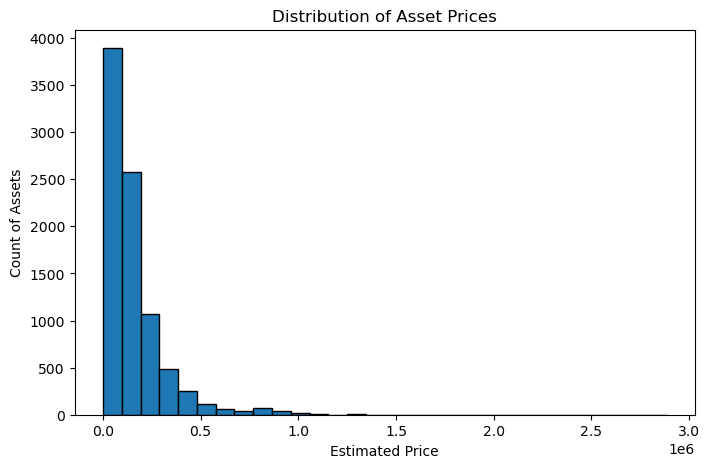

In [5]:
import matplotlib.pyplot as plt

df = pd.read_csv("predictions.csv")

plt.figure(figsize=(8,5))
plt.hist(df['estimated_price'], bins=30, edgecolor='black')
plt.xlabel("Estimated Price")
plt.ylabel("Count of Assets")
plt.title("Distribution of Asset Prices")
plt.show()

In [ ]:
# Region-wise Average Price (Bar Plot)

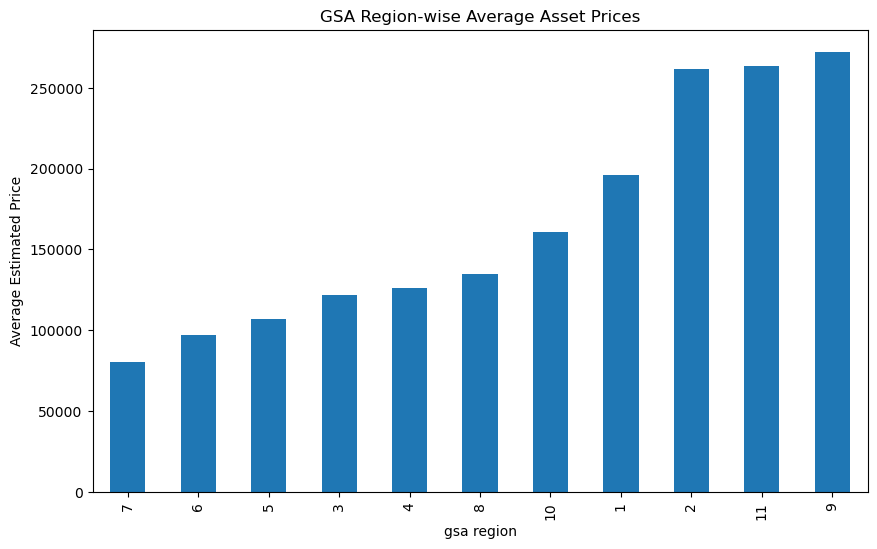

In [6]:
region_avg = df.groupby("gsa region")["estimated_price"].mean().sort_values()

plt.figure(figsize=(10,6))
region_avg.plot(kind="bar")
plt.ylabel("Average Estimated Price")
plt.title("GSA Region-wise Average Asset Prices")
plt.show()

In [ ]:
# Clusters

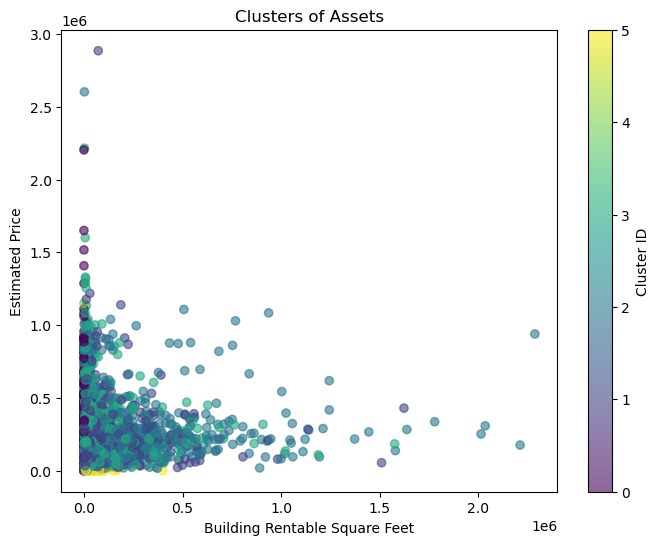

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(df['building rentable square feet'], df['estimated_price'], 
            c=df['Predicted_Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel("Building Rentable Square Feet")
plt.ylabel("Estimated Price")
plt.title("Clusters of Assets")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
# Correlation Heatmap

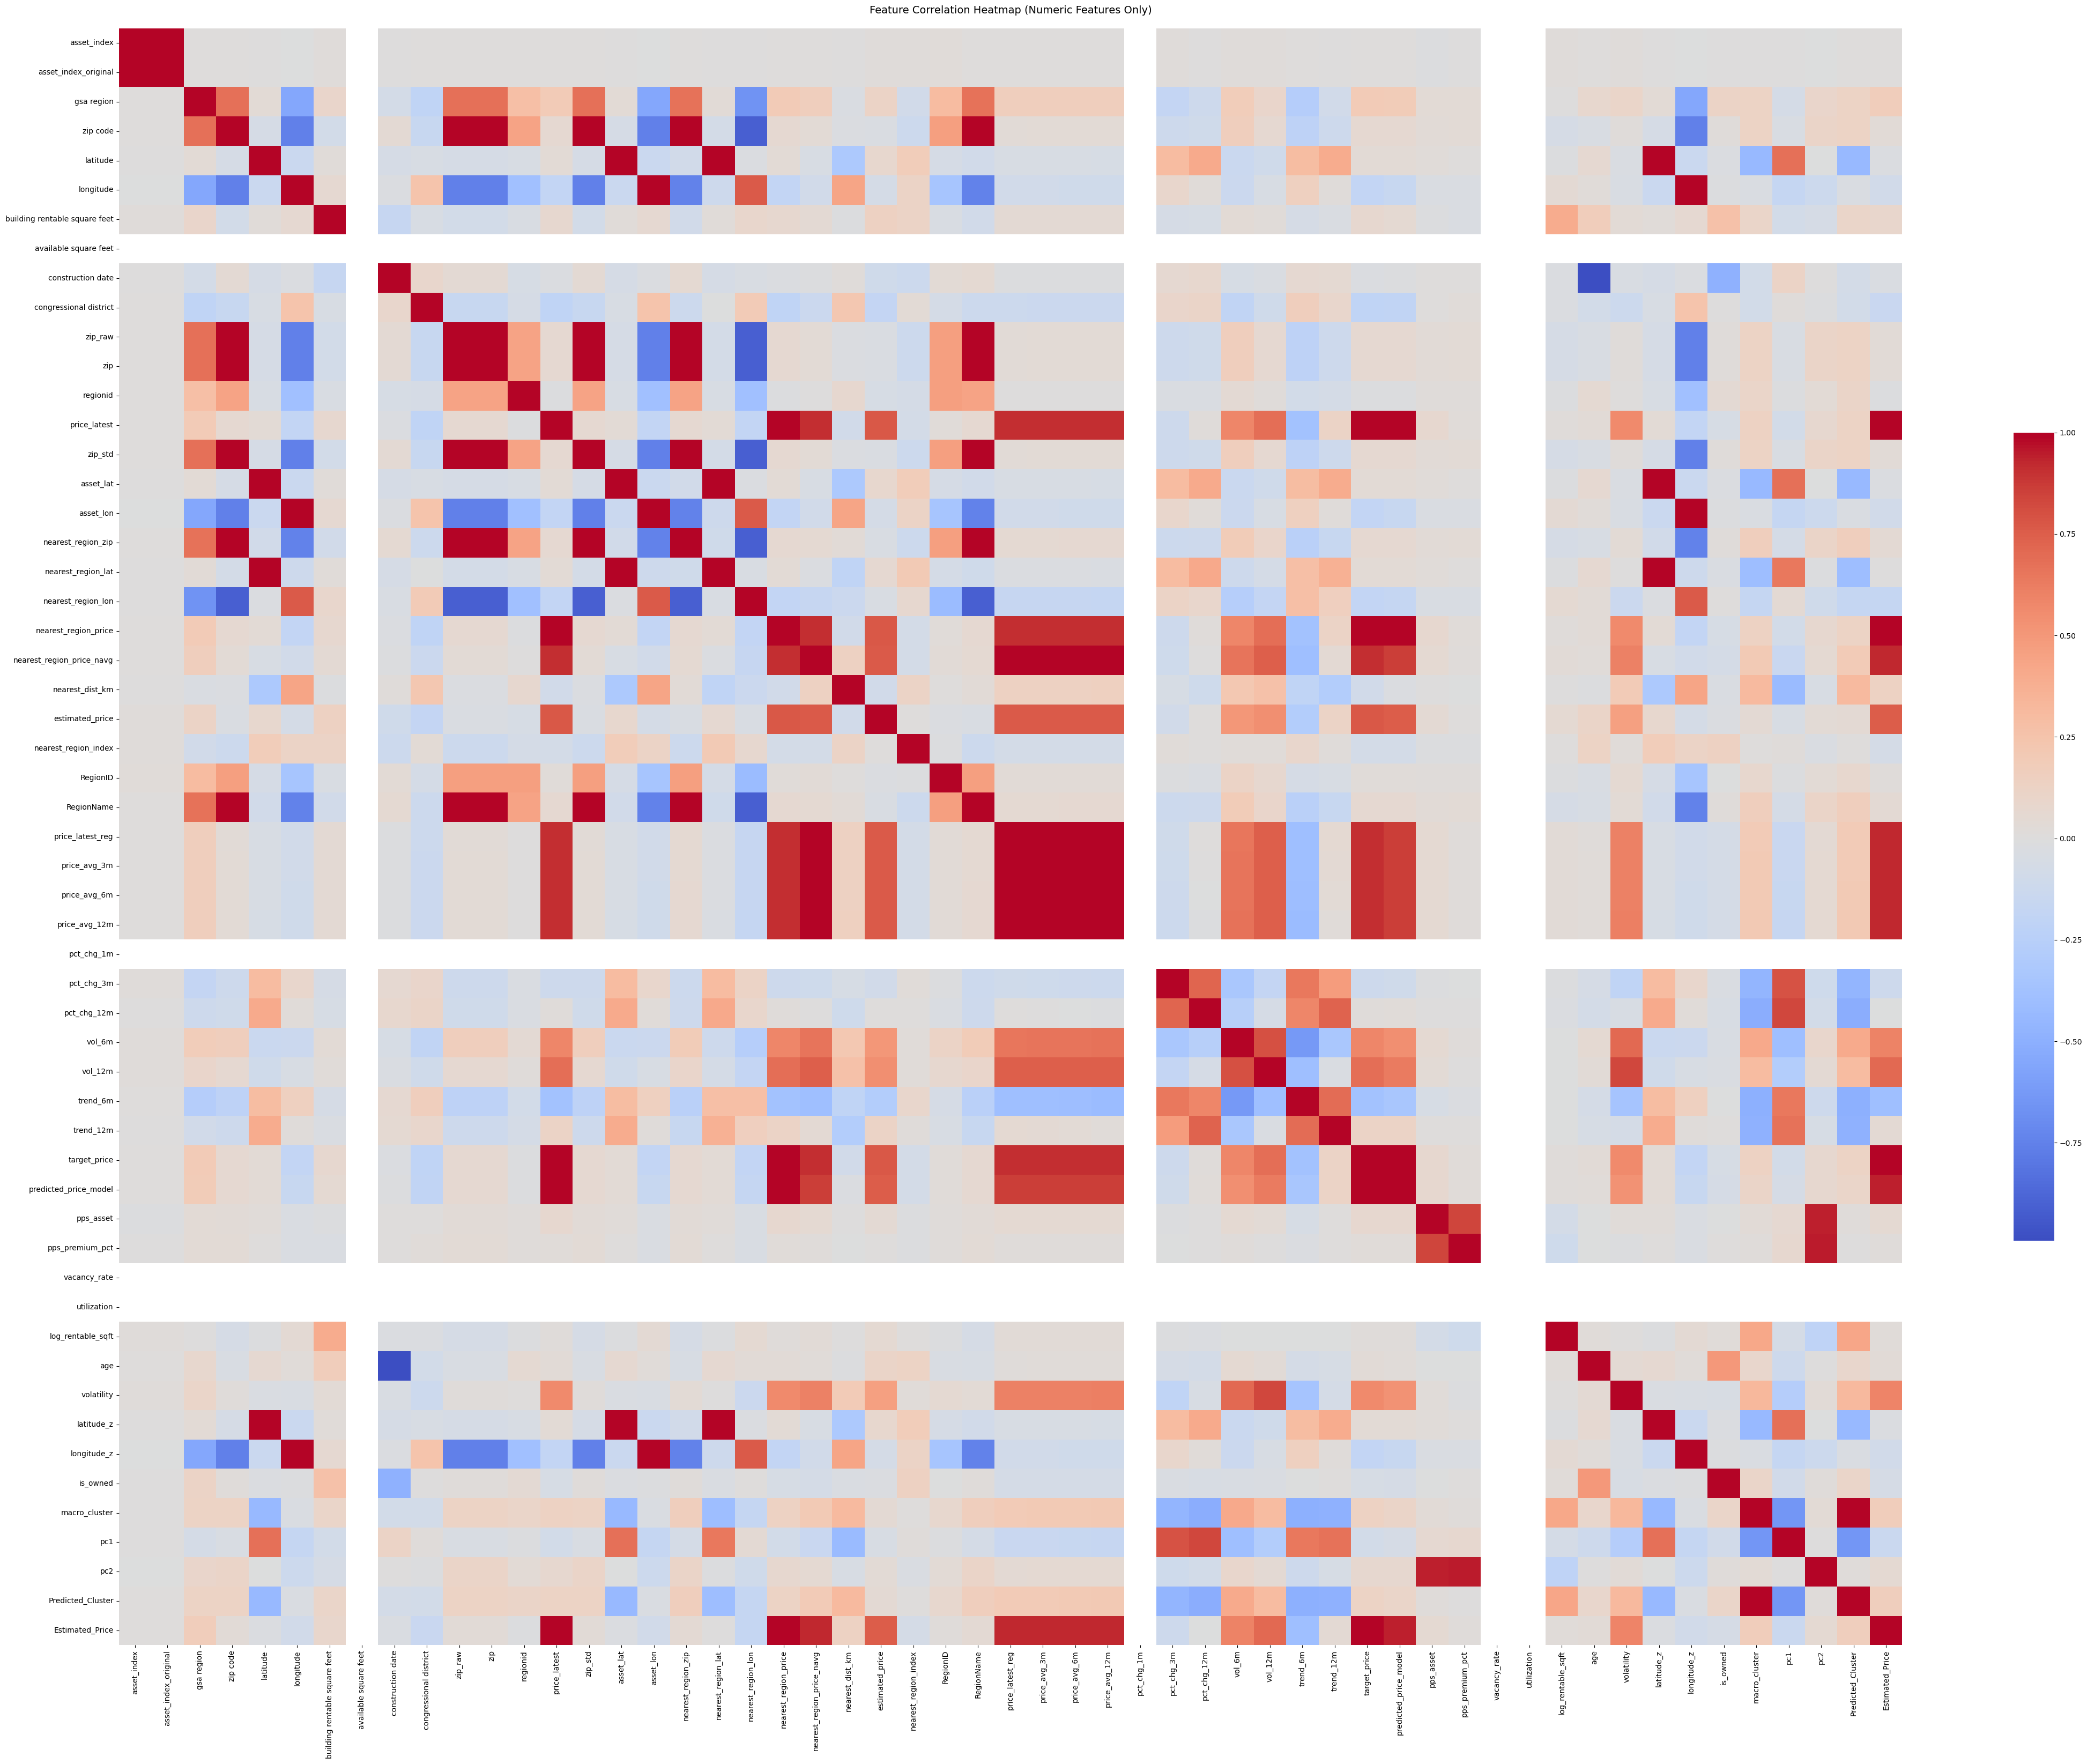

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64','float64'])

# Compute correlation matrix
corr = numeric_df.corr()

# Set figure size dynamically based on number of features
plt.figure(figsize=(len(corr.columns)*0.8, len(corr.columns)*0.6))

# Draw heatmap without annotations
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink': 0.5})

plt.title("Feature Correlation Heatmap (Numeric Features Only)", fontsize=14, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Cluster-wise Average Estimated Price (Bar Chart)

C:\Users\salon\AppData\Local\Temp\ipykernel_13200\1672127781.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_avg.values, y=cluster_avg.index, palette="viridis")


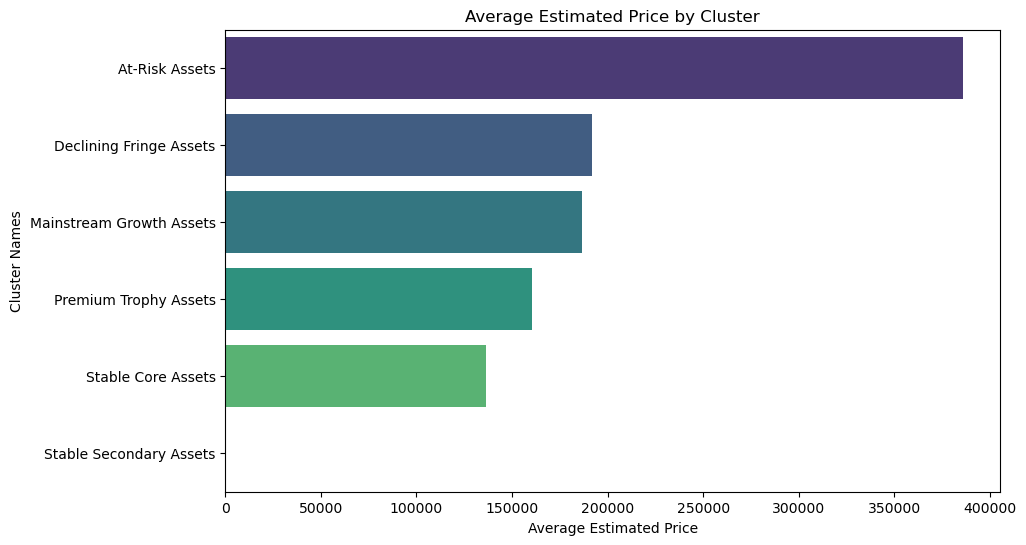

In [9]:
plt.figure(figsize=(10,6))
cluster_avg = df.groupby("cluster_name")["estimated_price"].mean().sort_values(ascending=False)
sns.barplot(x=cluster_avg.values, y=cluster_avg.index, palette="viridis")
plt.title("Average Estimated Price by Cluster")
plt.xlabel("Average Estimated Price")
plt.ylabel("Cluster Names")
plt.show()

In [ ]:
# Actual vs Predicted Prices (Scatter Plot)

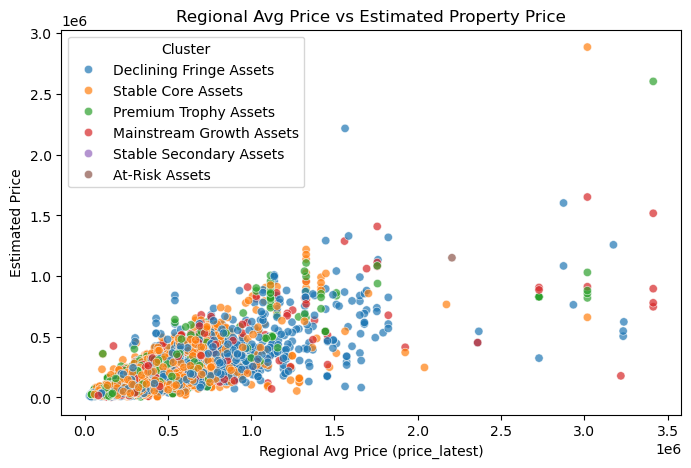

In [10]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['price_latest'], y=df['estimated_price'], hue=df['cluster_name'], alpha=0.7, palette="tab10")
plt.title("Regional Avg Price vs Estimated Property Price")
plt.xlabel("Regional Avg Price (price_latest)")
plt.ylabel("Estimated Price")
plt.legend(title="Cluster")
plt.show()